In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score

In [2]:
 warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('multivariate_T5.csv')

In [4]:
data_temp=df.values
print(np.shape(data_temp))
print(sum(df.LABEL == True))#导入数据

(2234, 37)
340


In [5]:
X, y = data_temp[:, 5:], data_temp[:, 0:5]

In [6]:
# upsampling
print('Number of recession samples before:',X[df.LABEL==1].shape[0])
print('Number of normal samples before:',X[df.LABEL==0].shape[0])
X_upsampled, y_upsampled = resample(X[df.LABEL==1], y[df.LABEL==1],
                                   replace=True,
                                   n_samples = X[df.LABEL==0].shape[0],
                                   random_state = 1)
print("Number of recession samples after:", X_upsampled.shape[0])

Number of recession samples before: 340
Number of normal samples before: 1894
Number of recession samples after: 1894


In [7]:
X = np.vstack((X[df.LABEL==0], X_upsampled))
y = np.vstack((y[df.LABEL==0], y_upsampled))

In [8]:
print(X.shape)
print(y.shape)

(3788, 32)
(3788, 5)


In [9]:
print(y)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0.]]


In [10]:
from sklearn.model_selection import train_test_split

X, y = X, y[:, 1:5]

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)#划分训练集
sum(y_test)#测试集里多少个萧条样本

array([156., 155., 127., 130.])

In [11]:
sum(y_train)#训练集里多少个萧条样本

array([365., 362., 296., 303.])

In [12]:
sum(y_test)#测试集里多少个萧条样本

array([156., 155., 127., 130.])

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [14]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)#标准化

In [15]:
## Tree pipeline
pipe_tree = make_pipeline(StandardScaler(),
                        #PCA(n_components=3),
                         DecisionTreeClassifier(criterion='gini', max_depth=8, random_state=1))

In [16]:
scores = cross_val_score(estimator = pipe_tree,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.79323308 0.78490566 0.75849057 0.80754717 0.77735849 0.75849057
 0.79245283 0.76981132 0.75471698 0.88301887]
CV accuracy: 0.788 +/- 0.036


In [17]:
pipe_tree.fit(X_train, y_train)
y_pred_tree = pipe_tree.predict(X_test)
print('Train Accuracy: %.3f' % pipe_tree.score(X_train, y_train))
print('Test Accuracy: %.3f' % pipe_tree.score(X_test, y_test))#忽略该块程序即可，为了可视化tree没用pipeline

Train Accuracy: 0.802
Test Accuracy: 0.785


In [18]:
tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=10, 
                              random_state=1)
tree.fit(X_train, y_train)
y_pred_tree2 = tree.predict(X_test_std)

In [19]:
print(y_pred_tree2)

[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [20]:
type(y_pred_tree2)

numpy.ndarray

In [21]:
a = np.mat([[1],[2],[3],[4]])

In [22]:
y_pred_tree3= np.mat(y_pred_tree2)

In [23]:
y_pred_tree3

matrix([[1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [24]:
y_pred_tree4 = y_pred_tree3*a

In [25]:
y_pred_tree4 = np.array(y_pred_tree4)

In [26]:
type(y_pred_tree4)

numpy.ndarray

In [27]:
y_pred_tree4 = np.array(y_pred_tree4).flatten()

In [28]:
y_pred_tree4

array([1., 0., 1., ..., 0., 1., 0.])

In [29]:
y_test1 = np.mat(y_test)
y_test2 = y_test1*a
y_test3 = np.array(y_test2)
y_test4 = np.array(y_test3).flatten()
y_test4

array([4., 0., 4., ..., 1., 0., 0.])

[[78  0  0  0]
 [83  0  0  0]
 [56  0  0  0]
 [62  0  0  6]]


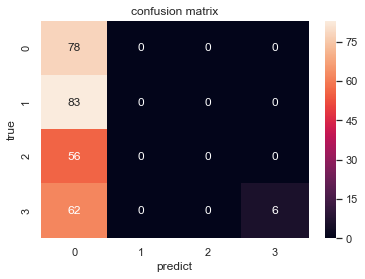

In [49]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
sns.set()
f,ax=plt.subplots()
y_true = y_test4
y_pred = y_pred_tree4
C2= confusion_matrix(y_true, y_pred, labels=[1,2,3,4])
print(C2) #打印出来看看
sns.heatmap(C2,annot=True,ax=ax) #画热力图

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴
plt.savefig('Pic/cm_multi5.png', dpi=300)

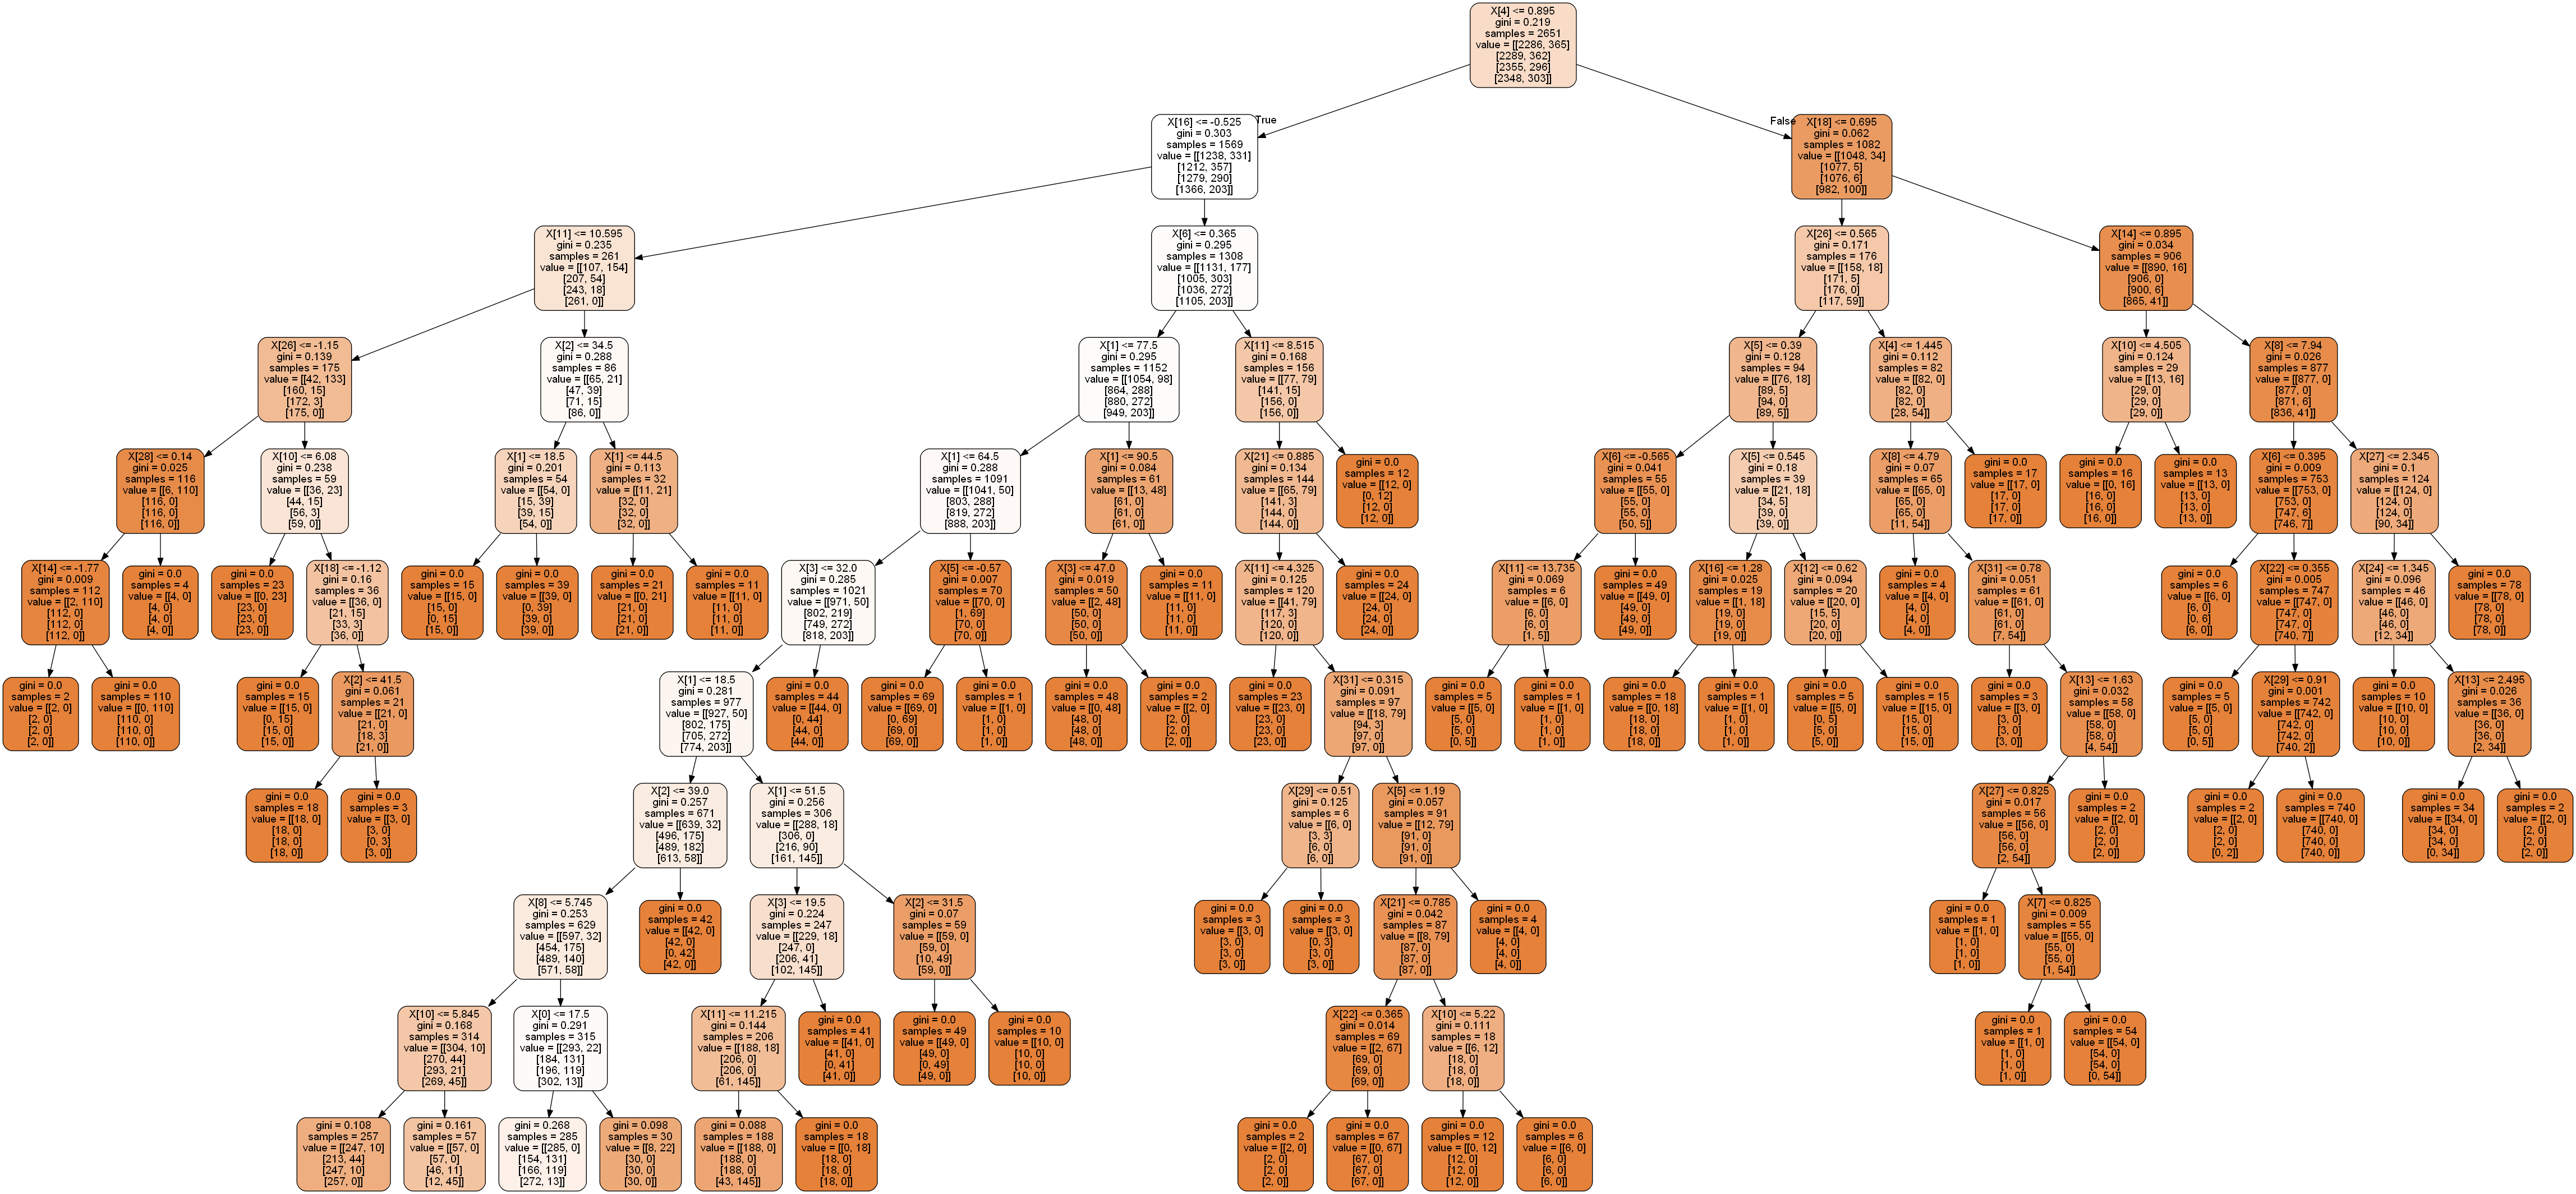

In [31]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           #class_names=['Setosa', 
                            #            'Versicolor',
                            #            'Virginica'],
                          # feature_names=['petal length', 
                          #                'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('Pic/tree_multi5.png') 

from IPython.display import Image
Image(filename='Pic/tree_multi5.png', width=600) 